In [1]:
from matplotlib.axes import Axes
from script.packetPreprocessing import *
from script.packetsHandler import *
import decimal
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import gc

In [2]:
fileNum=10
packets=readPcap(fileNum)
timestamp=readTimestamp(fileNum*10000)
packets=replaceTimestemp(packets,timestamp)

In [4]:
timestamps1,byteSlots0001, byteRates0001=splitToTimeSlot(packets, 0.0001)
timestamps2,byteSlots0002, byteRates0002 = splitToTimeSlot(packets, 0.0002)

In [5]:
timestamps1

[Decimal('1521118800.000107460'),
 Decimal('1521118800.000206567'),
 Decimal('1521118800.000311255'),
 Decimal('1521118800.000407472'),
 Decimal('1521118800.000514030'),
 Decimal('1521118800.000606112'),
 Decimal('1521118800.000705995'),
 Decimal('1521118800.000806130'),
 Decimal('1521118800.000906304'),
 Decimal('1521118800.001010850'),
 Decimal('1521118800.001106791'),
 Decimal('1521118800.001208693'),
 Decimal('1521118800.001311637'),
 Decimal('1521118800.001416564'),
 Decimal('1521118800.001506753'),
 Decimal('1521118800.001607068'),
 Decimal('1521118800.001706749'),
 Decimal('1521118800.001806252'),
 Decimal('1521118800.001917258'),
 Decimal('1521118800.002007537'),
 Decimal('1521118800.002107114'),
 Decimal('1521118800.002206244'),
 Decimal('1521118800.002306640'),
 Decimal('1521118800.002406821'),
 Decimal('1521118800.002506495'),
 Decimal('1521118800.002618976'),
 Decimal('1521118800.002706893'),
 Decimal('1521118800.002811648'),
 Decimal('1521118800.002906479'),
 Decimal('1521

In [7]:
data=pd.DataFrame({'timestamp':list(map(int,timestamps1)),
                  'byterate':list(map(int,byteRates0001))})

data.head()

# for label in fig.get_xticklabels():
#     if np.int(label.get_text()) % 100 == 0:  
#         label.set_visible(True)
#     else:
#         label.set_visible(False)

,timestamp,byterate
0,1.521119e+09,633309999
1,1.521119e+09,622079999
2,1.521119e+09,379149999
3,1.521119e+09,221769999
4,1.521119e+09,256299999


In [15]:
data["timestamp"][len(data)-1]


1521118800.202381

In [ ]:
fig=sns.lineplot(x='timestamp',y='byterate',data=data  )

# xticklabels	List[str]
# xticks

In [11]:
fig.set_xticks(np.arange(0,len(data),100))
fig.set_xticklabels(np.arange(0,len(data),100))
# fig.set_size_inches( 30, 10)
# np.arange(0, len(byteRates0001),100)

[Text(0, 0, '0'),
 Text(100, 0, '100'),
 Text(200, 0, '200'),
 Text(300, 0, '300'),
 Text(400, 0, '400'),
 Text(500, 0, '500'),
 Text(600, 0, '600'),
 Text(700, 0, '700'),
 Text(800, 0, '800'),
 Text(900, 0, '900'),
 Text(1000, 0, '1000'),
 Text(1100, 0, '1100'),
 Text(1200, 0, '1200'),
 Text(1300, 0, '1300'),
 Text(1400, 0, '1400'),
 Text(1500, 0, '1500'),
 Text(1600, 0, '1600'),
 Text(1700, 0, '1700'),
 Text(1800, 0, '1800'),
 Text(1900, 0, '1900'),
 Text(2000, 0, '2000')]

In [12]:
figure=fig.get_figure()
figure.set_size_inches(30,10)
figure.savefig("byterate_for_0_0001s_time_slot")

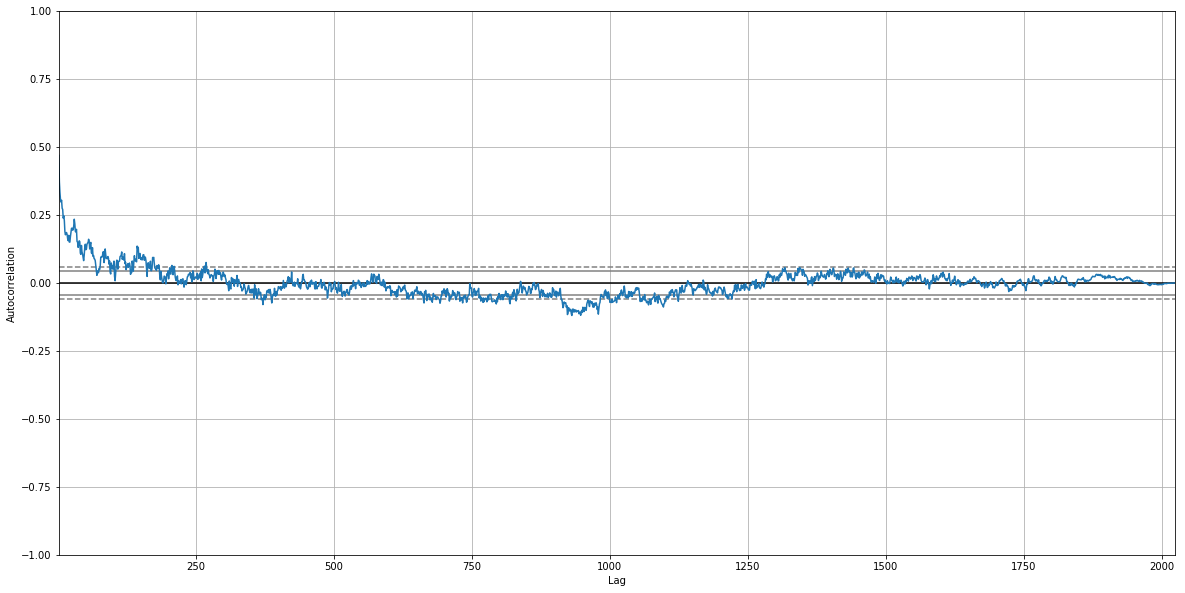

In [21]:
autofig=pd.plotting.autocorrelation_plot(list(map(int,byteRates0001)))
autofig.get_figure().set_size_inches(20,10)
autofig.get_figure().savefig("autocorrelation_plot")

In [114]:
del fig,figure
gc.collect()

NameError: name 'figure' is not defined